# Example 1 - A Traditional CNN based on LeNet / VGG16 - 2014

![CNN](https://i.imgflip.com/2n3h1m.jpg)

---

## LiveLossPlot - Plot the loss function live during training

https://github.com/stared/livelossplot

In [49]:
%%capture pip_install

!pip install livelossplot
!pip install tqdm

In [1]:
from tensorflow import keras

In [2]:
import os

import numpy as np
import pandas as pd

## Finding all Available Images in Data Folder

In [26]:
DATA_DIRECTORY_DOGS = "../CNN/data/dogs/"
DATA_DIRECTORY_CATS = "../CNN/data/cats/"

SAMPLE_SIZE = 10000

DOGS = os.listdir(DATA_DIRECTORY_DOGS)
CATS = os.listdir(DATA_DIRECTORY_CATS)

CATS_SAMPLE = np.random.choice( CATS, size=int(SAMPLE_SIZE/2), replace=False)
DOGS_SAMPLE = np.random.choice( DOGS, size=int(SAMPLE_SIZE/2), replace=False)

CATS_SAMPLE_FULLPATH = [DATA_DIRECTORY_CATS + file for file in CATS_SAMPLE]
DOGS_SAMPLE_FULLPATH = [DATA_DIRECTORY_DOGS + file for file in DOGS_SAMPLE]

ANIMALS = CATS_SAMPLE_FULLPATH + DOGS_SAMPLE_FULLPATH
np.random.shuffle(ANIMALS)

## Loading the Images as arrays

In [30]:
from tqdm import tnrange, tqdm_notebook, tqdm
from keras.preprocessing import image

images = []
labels = []

for animal_path in tqdm_notebook(ANIMALS,desc="Loading Images",unit="images"):
    img = image.load_img(animal_path, grayscale=False, color_mode="rgb", target_size=(50,50) )
    img_label = np.array([1,0])
    if "dog" in animal_path:
        img_label = np.array([0,1])
    try:
        images.append( image.img_to_array(img)/255 ) 
        labels.append(img_label)
    except:
        pass


In [31]:
import numpy as np

images_data=np.array(images)
class_labels=np.array(labels)

print(images_data.shape)

## Display first few training sample

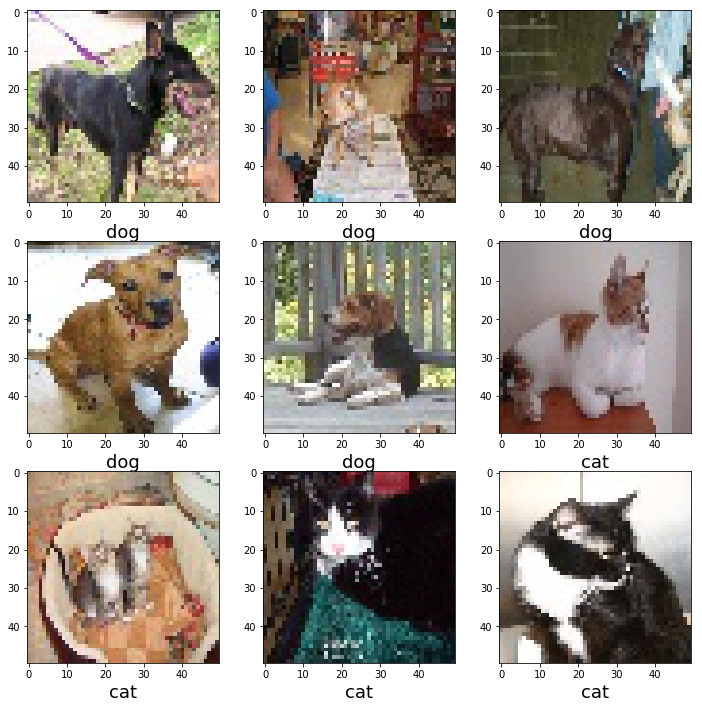

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

random_labels = class_labels[:9]
random_images = images_data[:9]
random_labels_titles = [ "dog" if l[1] > 0 else "cat" for l in random_labels]

for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(random_images[i])
    plt.xlabel(random_labels_titles[i],fontsize=18)
plt.show()

## Design a CNN

In [57]:
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout,BatchNormalization,Activation

## Traditional CNN - Inspired by the VGG16, 2014

- (?) Can we re-calcuate and confirm the first `Conv2D()` layer needs 896 parameters, with 32, 3x3 filters?
- (?) What is the most common `kernel_size` nowadays?
- (?) What is the consequence of changes in the `MaxPooling2D()` - for total number of parameters ?
- (?) Are the number of filters, in a traditional network like `VGG16`, stable, increasing, or descreasing as the layers stack?
- (?) Inception (2014), make use of `1x1` convolutions - what does a 1x1 convolution do and why is it usefull? - See
https://arxiv.org/pdf/1409.4842.pdf

In [59]:
model=Sequential()
model.add(Conv2D(kernel_size=(3,3),filters=32,activation="relu",input_shape=(50,50,3)))
model.add(Conv2D(kernel_size=(3,3),filters=32,activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(kernel_size=(3,3),filters=48,activation="relu"))
model.add(Conv2D(kernel_size=(3,3),filters=48,activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(100,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 48)        13872     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 48)        20784     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1200)              0         
__________

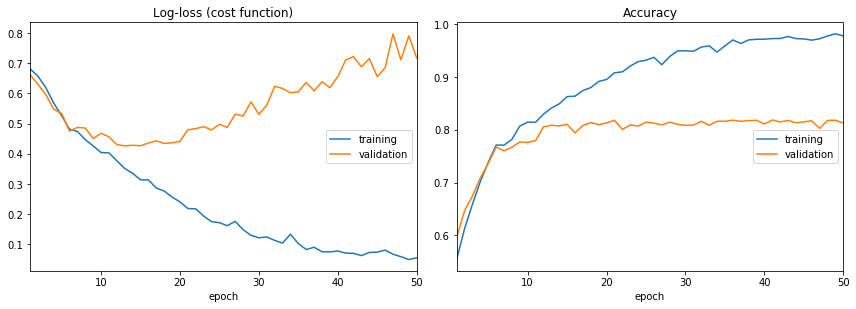

In [60]:
from livelossplot import PlotLossesKeras

model.fit(images_data,class_labels,validation_split=0.25,epochs=50,batch_size=150, callbacks=[PlotLossesKeras()],verbose=1)


## Uncomment lines to save/load a model

In [62]:
from keras.models import load_model

#model.save("models/my_own_cnn_model.hdf5")

#model = load_model("models/traditional_cnn_model.hdf5")

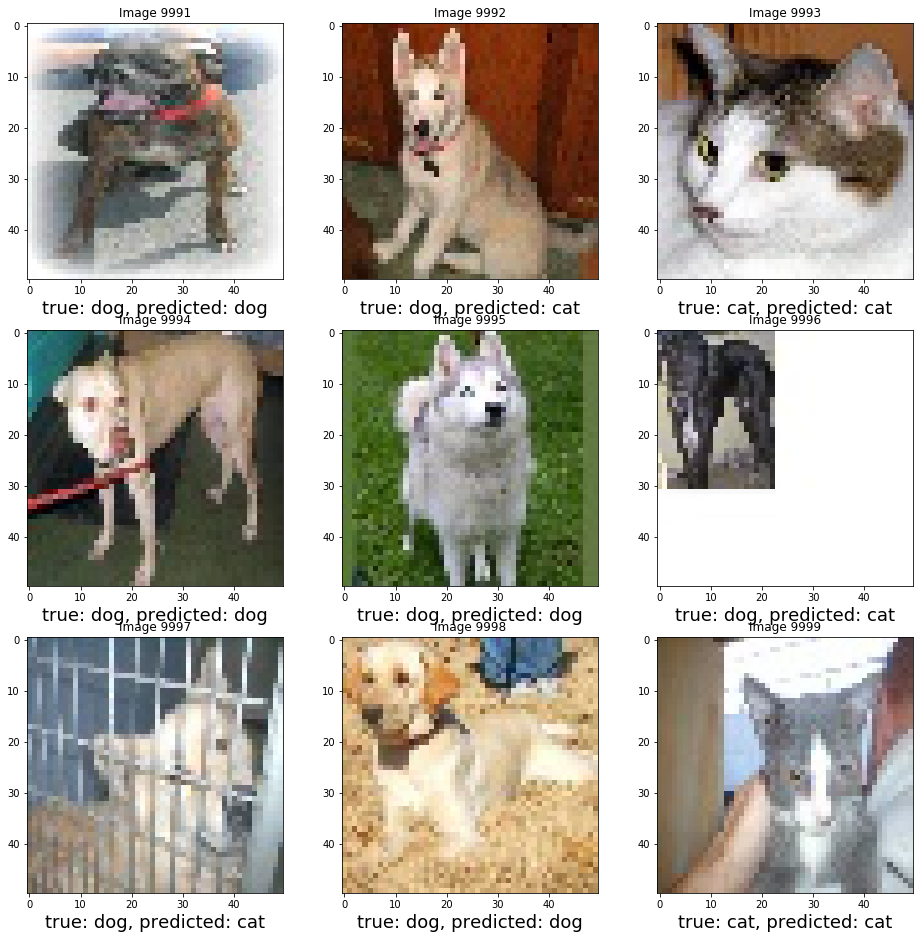

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))

tail_images = images_data[-9:]
tail_labels = class_labels[-9:]

predicted_labels = model.predict_classes(tail_images)

random_labels_titles = [ "true: dog" if l[1] > 0 else "true: cat" for l in tail_labels ]
predicted_labels = [ ", predicted: dog" if p > 0 else ", predicted: cat" for p in predicted_labels ]

new_labels = [ t + p for t,p in zip(random_labels_titles, predicted_labels)]

for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(tail_images[i])
    plt.xlabel(new_labels[i],fontsize=18)
    plt.title("Image {}".format(len(class_labels)-9+i))
plt.show()

## Experimental - Class Activation Heatmaps

In [67]:
%%capture
!pip install keras-vis

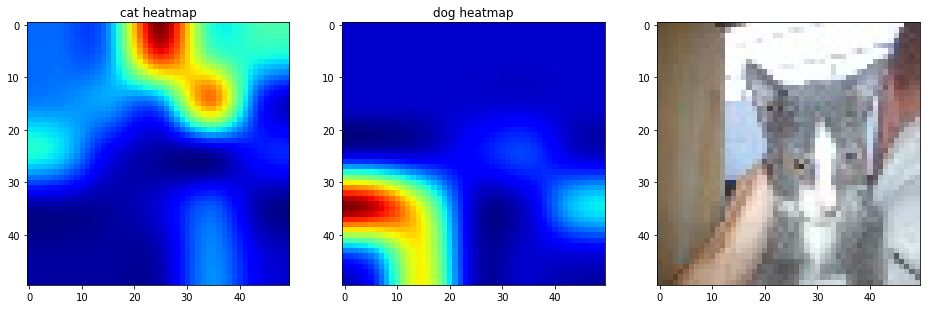

In [68]:
%matplotlib inline
from vis.visualization import visualize_cam, visualize_saliency, visualize_activation

image_index = 9999

cat_activation_heatmap = visualize_cam(model, 9, filter_indices=[0], seed_input=images_data[image_index])
dog_activation_heatmap = visualize_cam(model, 9, filter_indices=[1], seed_input=images_data[image_index])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(cat_activation_heatmap, cmap='jet')
plt.title("cat heatmap")
plt.subplot(1,3,2)
plt.imshow(dog_activation_heatmap, cmap='jet')
plt.title("dog heatmap")
plt.subplot(1,3,3)
plt.imshow(images_data[image_index])